In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout,Dense,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
#load the data

training_set = pd.read_csv('fashion-mnist_train.csv')
testing_set = pd.read_csv('fashion-mnist_test.csv')



In [4]:
#Preprocess the data 
# Reshape the given csv into the original images


# pixels values for each image
X_train = np.array(training_set.iloc[:,1:])
X_test = np.array(testing_set.iloc[:,1:])

X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')


X_train = X_train/255
X_test = X_test/255

#label for each image
target = training_set.iloc[:,0]
y_train = to_categorical(np.array(training_set.iloc[:,0])) 
y_test = to_categorical(np.array(testing_set.iloc[:,0]))

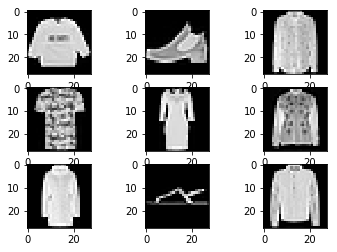

In [9]:
# Check if the reshaping worked by displaying the 9 first images 

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(np.squeeze(X_train[i]), cmap='gray')
plt.show()

In [5]:
# Building a cnn model
shape = (28,28,1)
number_of_classes = y_test.shape[1]
def create_model():
    model = Sequential()
    model.add(Conv2D(32,(5,5),activation ='relu',input_shape = shape ))
    model.add(Conv2D(32,(5,5),activation ='relu',input_shape = shape ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(5,5),activation ='relu' ))
    model.add(Conv2D(64,(5,5),activation ='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model


In [8]:
# Evaluate the model performance


model = KerasClassifier(build_fn = create_model, epochs=3, batch_size=128, verbose=0)
model.get_params()
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#results = cross_val_score(model, X_train, target, cv=kfold)
#print(results)


{'batch_size': 128,
 'build_fn': <function __main__.create_model>,
 'epochs': 3,
 'verbose': 0}

In [6]:
#  Training the model with augmented data 

epochs = 10
batch_size = 150

datagenerator = ImageDataGenerator(
width_shift_range=0.1,
height_shift_range=0.1,
    
)
datagenerator.fit(X_train)
train_generator = datagenerator.flow(X_train, y_train, batch_size = batch_size)
model = create_model()
history2 = model.fit_generator(
        train_generator,
        steps_per_epoch = 400,
        epochs = epochs,
        validation_data = (X_test,y_test),
        )

Epoch 1/10
400/400 [==============================] - 364s 909ms/step - loss: 0.8406 - acc: 0.6772 - val_loss: 0.5336 - val_acc: 0.7866
Epoch 2/10
400/400 [==============================] - 361s 903ms/step - loss: 0.5823 - acc: 0.7759 - val_loss: 0.4535 - val_acc: 0.8215
Epoch 3/10
400/400 [==============================] - 365s 913ms/step - loss: 0.5050 - acc: 0.8069 - val_loss: 0.3981 - val_acc: 0.8500
Epoch 4/10
400/400 [==============================] - 365s 912ms/step - loss: 0.4542 - acc: 0.8285 - val_loss: 0.3392 - val_acc: 0.8731
Epoch 5/10
400/400 [==============================] - 364s 911ms/step - loss: 0.4152 - acc: 0.8473 - val_loss: 0.3162 - val_acc: 0.8834
Epoch 6/10
400/400 [==============================] - 363s 909ms/step - loss: 0.3847 - acc: 0.8592 - val_loss: 0.2982 - val_acc: 0.8845
Epoch 7/10
400/400 [==============================] - 363s 908ms/step - loss: 0.3667 - acc: 0.8652 - val_loss: 0.2979 - val_acc: 0.8865
Epoch 8/10
400/400 [============================

In [34]:
# Training the model
batch_size = 150
epochs = 18
model = create_model()
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/18
60000/60000 [==============================] - 363s 6ms/step - loss: 0.7377 - acc: 0.7215 - val_loss: 0.4679 - val_acc: 0.8292
Epoch 2/18
60000/60000 [==============================] - 388s 6ms/step - loss: 0.4532 - acc: 0.8342 - val_loss: 0.3484 - val_acc: 0.8742
Epoch 3/18
60000/60000 [==============================] - 439s 7ms/step - loss: 0.3723 - acc: 0.8659 - val_loss: 0.3154 - val_acc: 0.8842
Epoch 4/18
60000/60000 [==============================] - 489s 8ms/step - loss: 0.3371 - acc: 0.8781 - val_loss: 0.3041 - val_acc: 0.8882
Epoch 5/18
60000/60000 [==============================] - 443s 7ms/step - loss: 0.3109 - acc: 0.8874 - val_loss: 0.2716 - val_acc: 0.8962
Epoch 6/18
60000/60000 [==============================] - 325s 5ms/step - loss: 0.2924 - acc: 0.8933 - val_loss: 0.2630 - val_acc: 0.9001
Epoch 7/18
60000/60000 [==============================] - 389s 6ms/step - loss: 0.2730 - acc: 0.9016 - val_loss: 0.2646 - 

In [7]:
# Evaluate the model 
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.278818559885
Test accuracy: 0.8911


In [8]:
# Make predictions about the classes
predictions = model.predict_classes(X_test,batch_size=150)  


In [9]:
# Save the classification

filename = 'cnn_classification3.csv';
PictureID = list(range(1,len(predictions)+1))
submission = pd.DataFrame({'Clothe_category':predictions })
submission.to_csv(filename,header = True, index = False)
print('Saved file: ' + filename)

Saved file: cnn_classification3.csv


In [10]:
# Data Model visualization
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
__________

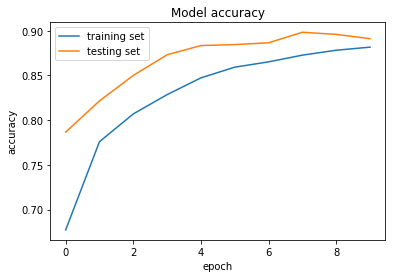

In [11]:
# Accuracy visualization
training_accuracy = history2.history['acc']
testing_accuracy = history2.history['val_acc']
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.title('Model accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

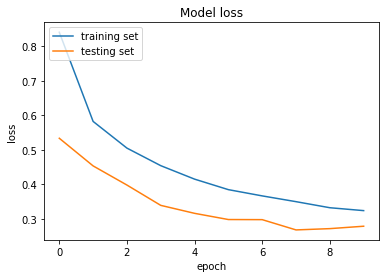

In [12]:
# Loss visualization

training_loss = history2.history['loss']
testing_loss = history2.history['val_loss']
plt.plot(training_loss)
plt.plot(testing_loss)
plt.title('Model loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()
